In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('Trim_feature_Loan_2007_2018Q4.csv')
df.shape

(1345310, 31)

# PART 1: QUICK DATA CHECK

## Data table
| ----------- | ----------- |----------- |
| ## thông tin khoản vay       |||
| 0           | id                  | id of loan |
| 1           | loan_status         |	Current status of the loan|
| 2           |	loan_amnt           |	The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value. |
| 3           |	term 	            |The number of payments on the loan. Values are in months and can be either 36 or 60.|
| 4           |	int_rate            | 	Interest Rate on the loan|
| 5           |	installment         | 	The monthly payment owed by the borrower if the loan originates.|
| 6           |	grade               | 	LC assigned loan grade|
| 7           |	sub_grade           | 	LC assigned loan subgrade|
| 8           | issue_d             | 	The month which the loan was funded|
| 9           | purpose             | 	A category provided by the borrower for the loan request.|
| 10          | title               | 	The loan title provided by the borrower|
| 11          | application_type    |	Indicates whether the loan is an individual application or a joint application with two co-borrowers|
| 12          | initial_list_status | 	The initial listing status of the loan. Possible values are – W, F|
| ## thông tin về người vay    |||
| 13          |	emp_title           | 	The job title supplied by the Borrower when applying for the loan.*|
| 14          |	emp_length          | 	Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.|
| 15          | zip_code            | 	The first 3 numbers of the zip code provided by the borrower in the loan application.|
| 16          | addr_state          | 	The state provided by the borrower in the loan application|
| ## thông tin lịch sử tài chính của người vay|||
| 17          |	home_ownership      | 	The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER|
| 18          |	annual_inc          | 	The self-reported annual income provided by the borrower during registration.|
| 19          | verification_status | 	Indicates if income was verified by LC, not verified, or if the income source was verified|
| 20          | dti                 | 	A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.|
| 21          | earliest_cr_line    | 	The month the borrower's earliest reported credit line was opened|
| 22          | open_acc            | 	The number of open credit lines in the borrower's credit file.|
| 23          | pub_rec             | 	Number of derogatory public records|
| 24          | revol_bal           | 	Total credit revolving balance|
| 25          | revol_util          | 	Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.|
| 26          | total_acc           | 	The total number of credit lines currently in the borrower's credit file|
| 27          | mort_acc            |	Number of mortgage accounts.|
| 28          | pub_rec_bankruptcies |	Number of public record bankruptcies|
| 29          | fico_range_high     | The upper boundary range the borrower’s FICO at loan origination belongs to|
| 30          | fico_range_low      | The lower boundary range the borrower’s FICO at loan origination belongs to|

In [3]:
def check_missed_values(df):
    df_null_percentage = df.isnull().sum() / df.shape[0] * 100
    df_null_percentage = df_null_percentage.drop(df_null_percentage[df_null_percentage == 0].index).sort_values(ascending= False).reset_index()
    df_null_percentage.columns = ["Feature", "Percentage"]
    return df_null_percentage

null_df = check_missed_values(df)

<AxesSubplot:xlabel='Percentage', ylabel='Feature'>

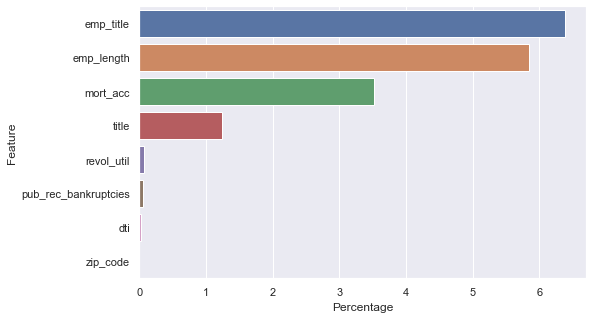

In [4]:
plt.figure(figsize=(8,5))
sns.barplot(x=  null_df["Percentage"] , y= null_df["Feature"] )

# PART 2: Exploratory Data Analysis


Pearson correlation matrix

We use the Pearson correlation coefficient to examine the strength and direction of the linear relationship between two continuous variables.
We can see a very strong correlation between loan_amnt and installment. (The monthly payment owed by the borrower if the loan originates)
and absolutely positive correlation between fico_range_high and fico_range_low



<AxesSubplot:title={'center':'Pearson Correlation Matrix'}>

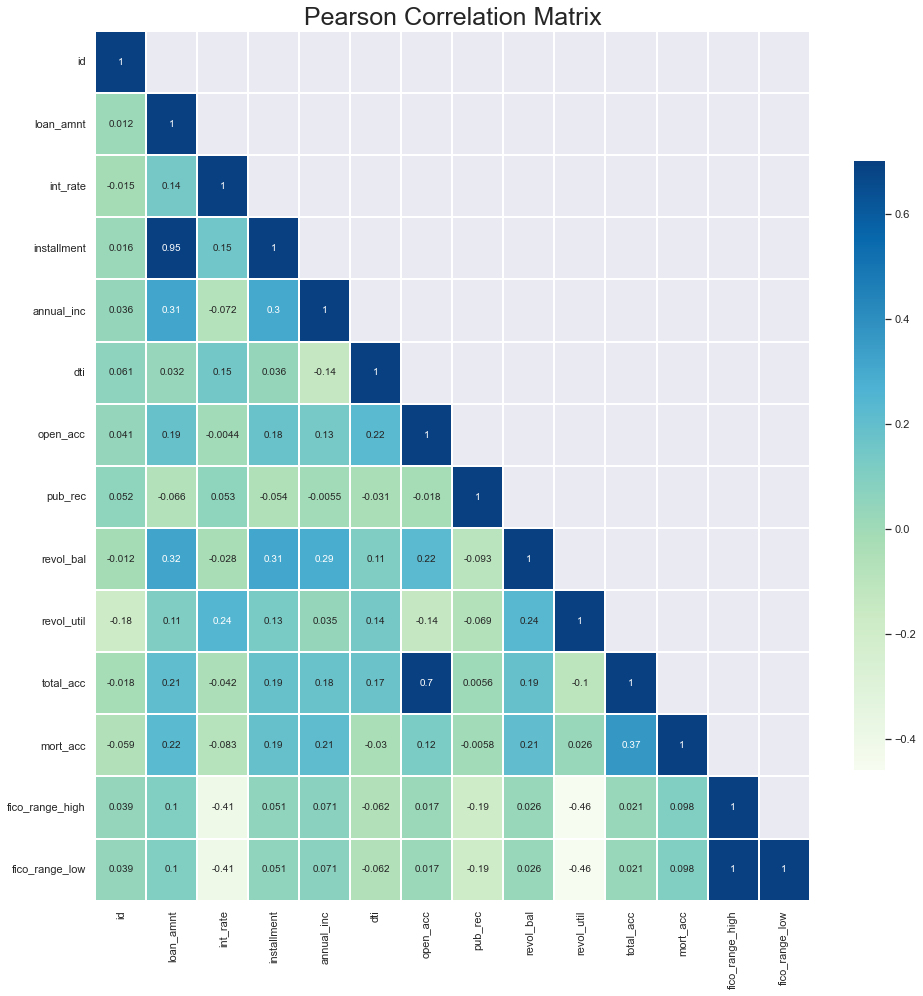

In [5]:
plt.figure(figsize=(16,16))
numeric_df_corr = df.drop(['pub_rec_bankruptcies'], axis= 1).corr()
plt.title('Pearson Correlation Matrix',fontsize=25)
mask = np.zeros_like(numeric_df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False
sns.heatmap(numeric_df_corr, linewidths=0.25, vmax=0.7, mask= mask, cmap="GnBu", annot=True, annot_kws={"size":10}, cbar_kws={"shrink": .7})

In [6]:
def plot_pie(table, column,ax= None, order= None):
    if ax == None:
        fig, ax =plt.subplots(figsize = (10, 4))
    data = table[column].value_counts()
    if order != None:
        data = data.reindex(order)

    ax.pie(data.values, labels=data.index, autopct='%1.1f%%', startangle=90)
    ax.text(0.1, 1.2, f'Distribution of {column}')
    ax.get_legend()

def stacked_hbar_chart(df, feature, column, target, ax= None, order= None):
    if ax == None:
        fig, ax =plt.subplots(figsize = (16, 10))
    pivot_df = pd.pivot_table(df, index=feature, columns= column,values=target, aggfunc=len, sort=False)
    if order != None:
        pivot_df = pivot_df.reindex(order)

    ax = pivot_df.div(pivot_df.sum(axis=1),axis=0).plot(kind='barh', title=f'Charged-Off-rate based on {feature}',stacked=True, ax= ax)


    ax.get_legend()

    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        if x != 0:
            x = 0.9
        ax.annotate('{:.1%}'.format(width),(x + 0.05, y + 0.13))

def kde_plot(df, x):
    fig, ax =plt.subplots(figsize = (16, 10))
    sns.kdeplot(df[df['loan_status'] == 'Fully Paid'][x], color="Red", shade = True)
    sns.kdeplot(df[df['loan_status'] == 'Charged Off'][x], color="Blue", shade= True)
    ax.legend(['Fully Paid','Charged Off'], loc='upper right')
    ax.set_ylabel('Density')
    ax.set_xlabel(f'{x}')
    ax.set_title(f'Distribution of {x} by loan_status')

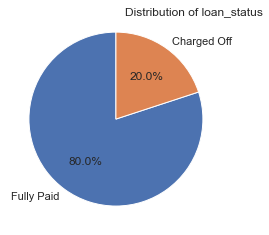

In [7]:
fig, ax =plt.subplots(figsize = (10, 4))
plot_pie(df, 'loan_status', ax= ax)

#Not very imbalance data set

<AxesSubplot:xlabel='loan_amnt', ylabel='loan_status'>

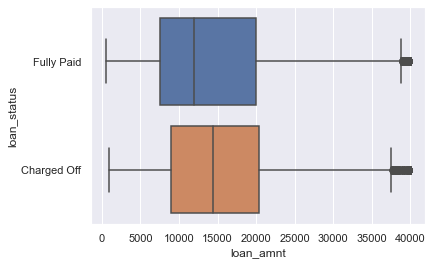

In [8]:
sns.boxplot(df['loan_amnt'], df['loan_status'])

# Charged Off tend to have higher loan amount

In [9]:
df['y'] = df['loan_status'].apply(lambda x:0 if x == 'Charged Off' else 1)

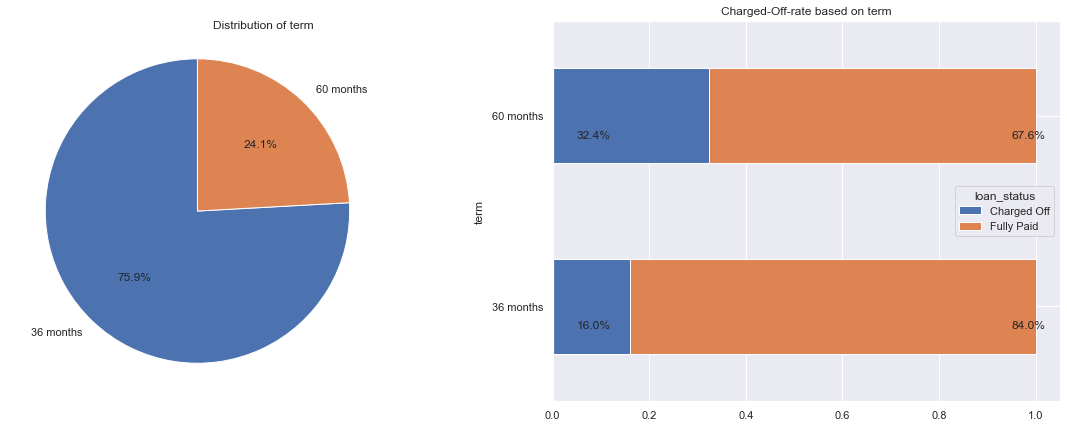

In [10]:
fig, ax =plt.subplots(1,2, figsize = (20, 7))
plot_pie(df, 'term', ax= ax[0])
stacked_hbar_chart(df,'term', 'loan_status', 'y', ax= ax[1])

# About 76% of the completed loans have three-year periods, and the rest have five-year periods

# Loans with five-year periods are more than twice as likely to charge-off as loans with three-year periods

<AxesSubplot:xlabel='int_rate', ylabel='loan_status'>

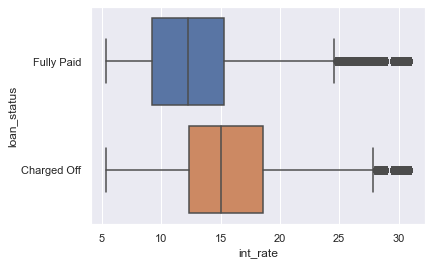

In [11]:
sns.boxplot(df['int_rate'], df['loan_status'])

In [12]:
# Charged Off Loans tend to have much higher interest rate

<AxesSubplot:xlabel='installment', ylabel='loan_status'>

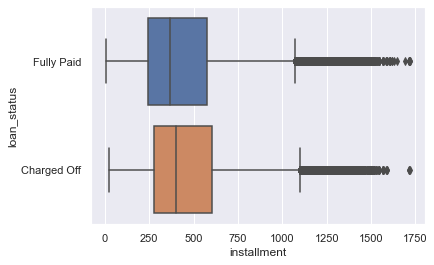

In [13]:
sns.boxplot(df['installment'], df['loan_status'])

In [14]:
# Charged-off loans tend to have higher installments. ($30 higher installment)

<AxesSubplot:xlabel='sub_grade', ylabel='count'>

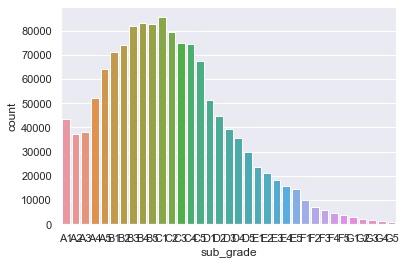

In [15]:
sns.countplot(df['sub_grade'], order=sorted(df['sub_grade'].unique()))

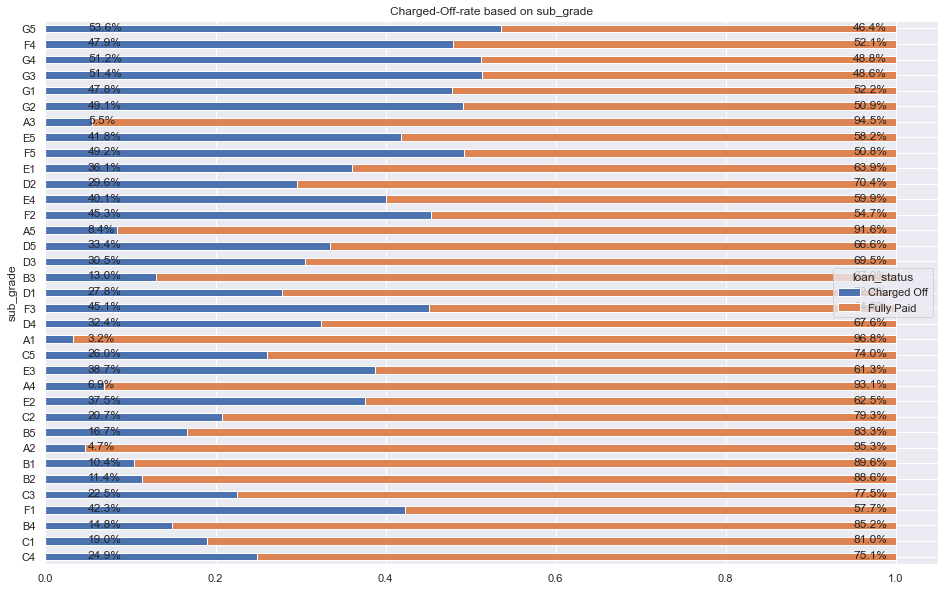

In [16]:
stacked_hbar_chart(df, 'sub_grade', 'loan_status', 'y')

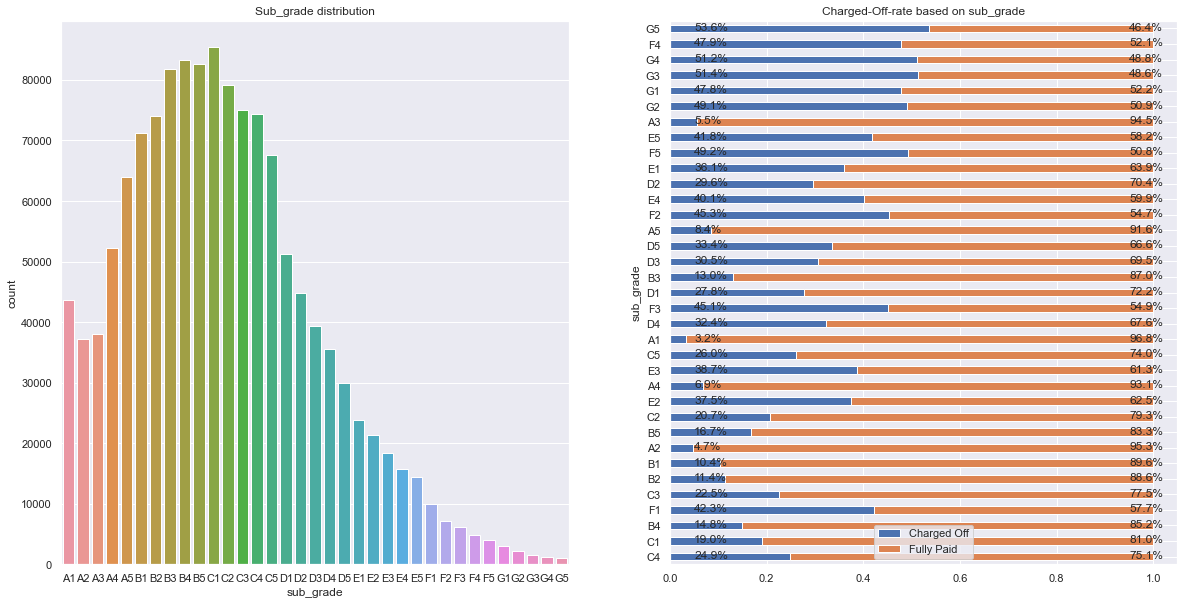

In [17]:
fig, ax =plt.subplots(1,2, figsize = (20, 10))
sns.countplot(df['sub_grade'], order=sorted(df['sub_grade'].unique()), ax= ax[0])
ax[0].set_title('Sub_grade distribution')
stacked_hbar_chart(df, 'sub_grade', 'loan_status', 'y', ax= ax[1])
plt.legend(loc= 8)

In [18]:
# There's a clear trend that the worse the grade and the sub-grade of the loan the higher chance the loan is Charged Off

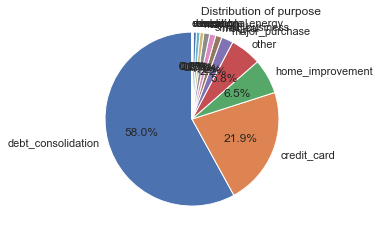

In [19]:
plot_pie(df, 'purpose')
# About half of the loan is about debt_consolidation

In [20]:
data = df['purpose'].value_counts(normalize= True)
data[3] = data[3] + sum(data[4:])
data = data[:4]
data

debt_consolidation    0.580031
credit_card           0.219488
home_improvement      0.065044
other                 0.135438
Name: purpose, dtype: float64

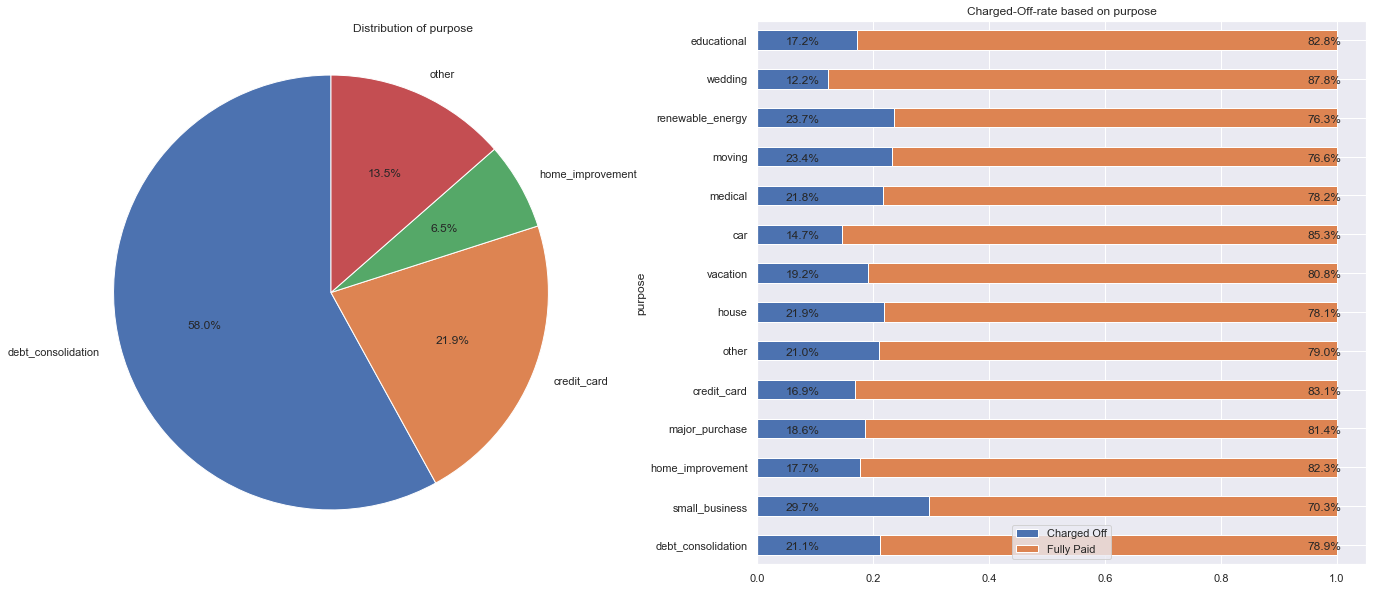

In [21]:
fig, ax =plt.subplots(1, 2, figsize = (24, 10))
ax[0].pie(data.values, labels=data.index, autopct='%1.1f%%', startangle=90)
ax[0].text(0.1, 1.2, f'Distribution of purpose')
ax[0].get_legend()
stacked_hbar_chart(df, 'purpose', 'loan_status', 'y', ax= ax[1])
plt.legend(loc= 8)

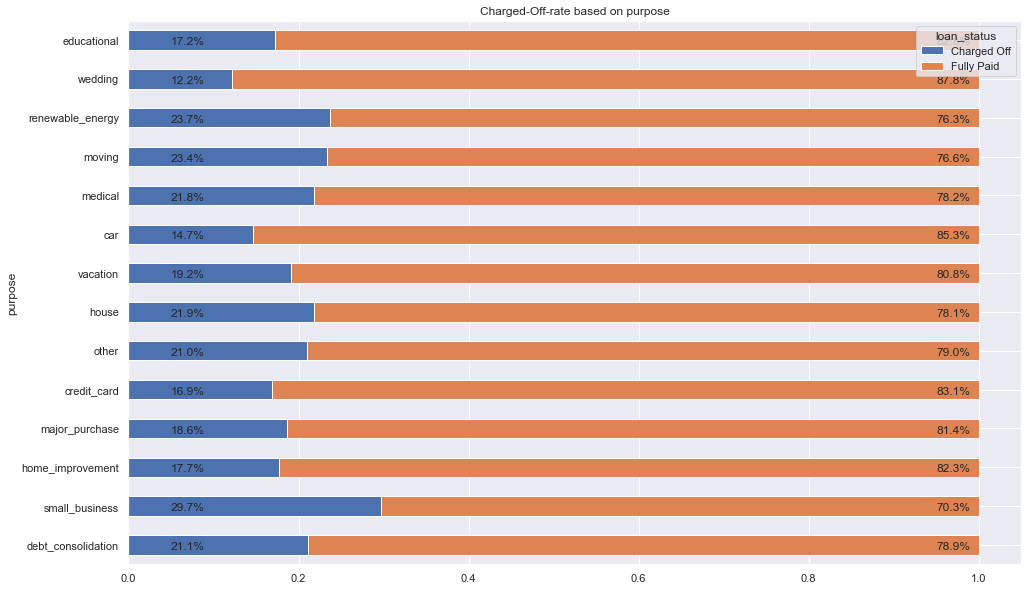

In [22]:
stacked_hbar_chart(df, 'purpose', 'loan_status', 'y')

In [23]:
# Leading the Charged Off rate based on purpose is Small_business followed by renewable_energy, moving, house and debt_consolidation respectively

In [24]:
# Joint App have slight higher chance to be Charged Off

In [25]:
df.emp_title.nunique()

378353

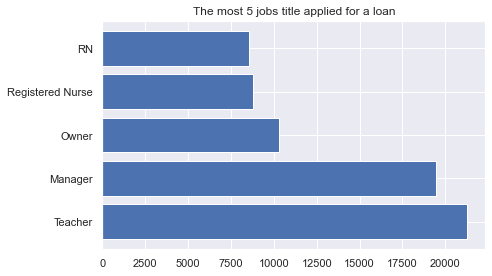

In [26]:
plt.figure(figsize=(7, 4))
plt.barh(df.emp_title.value_counts()[:5].index, df.emp_title.value_counts()[:5])
plt.title("The most 5 jobs title applied for a loan")
plt.tight_layout()

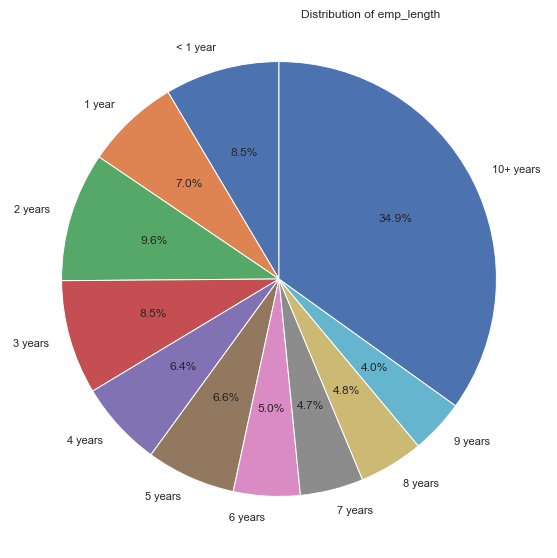

In [27]:
fig, ax =plt.subplots(figsize = (10, 10))
plot_pie(df, 'emp_length', ax= ax,order=['< 1 year', '1 year', '2 years','3 years', '4 years', '5 years','6 years', '7 years', '8 years','9 years','10+ years'])

In [28]:
def emp_role(x):
    if x in ['< 1 year', '1 year', '2 years']:
        return 'Fresher'
    elif x in ['3 years', '4 years', '5 years']:
        return 'Middle Senior'
    elif x in ['6 years', '7 years', '8 years','9 years']:
        return 'Senior'
    elif x in ['10+ years']:
        return 'Expert'

df['emp_role'] = df['emp_length'].apply(emp_role)

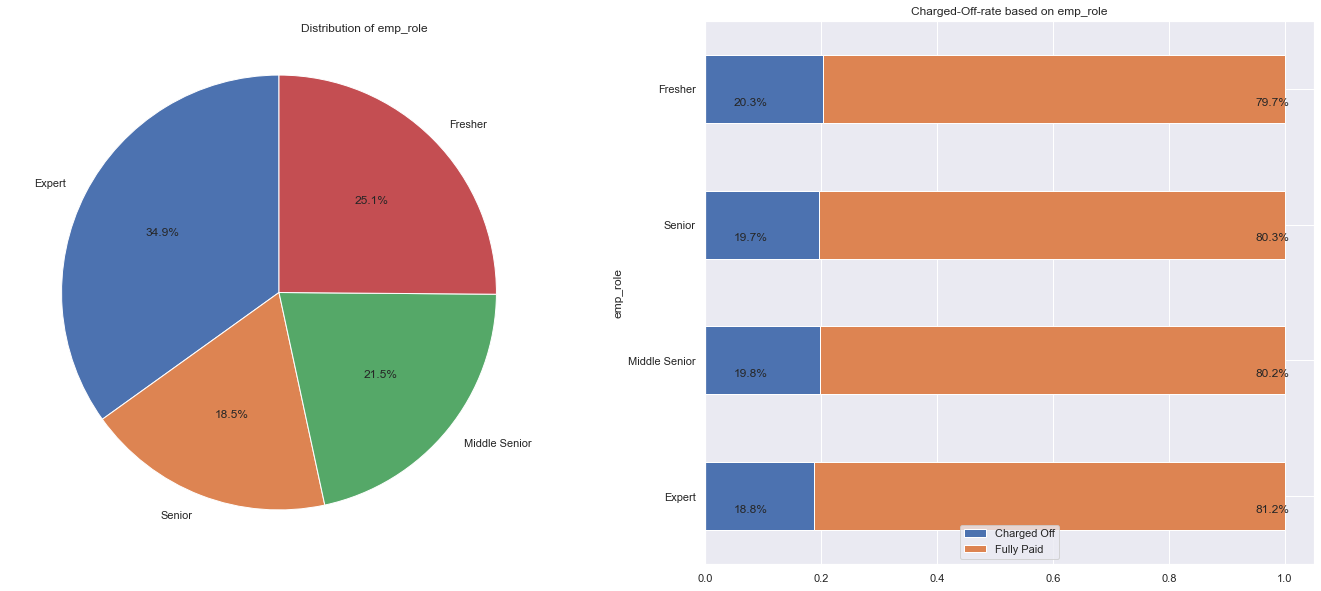

In [29]:
fig, ax =plt.subplots(1,2, figsize = (24, 10))
plot_pie(df, 'emp_role', ax= ax[0], order=['Expert','Senior','Middle Senior','Fresher'])
stacked_hbar_chart(df, 'emp_role', 'loan_status', 'y', ax= ax[1])
plt.legend(loc= 8)

In [30]:
# zip_code drop
# addr_state keep

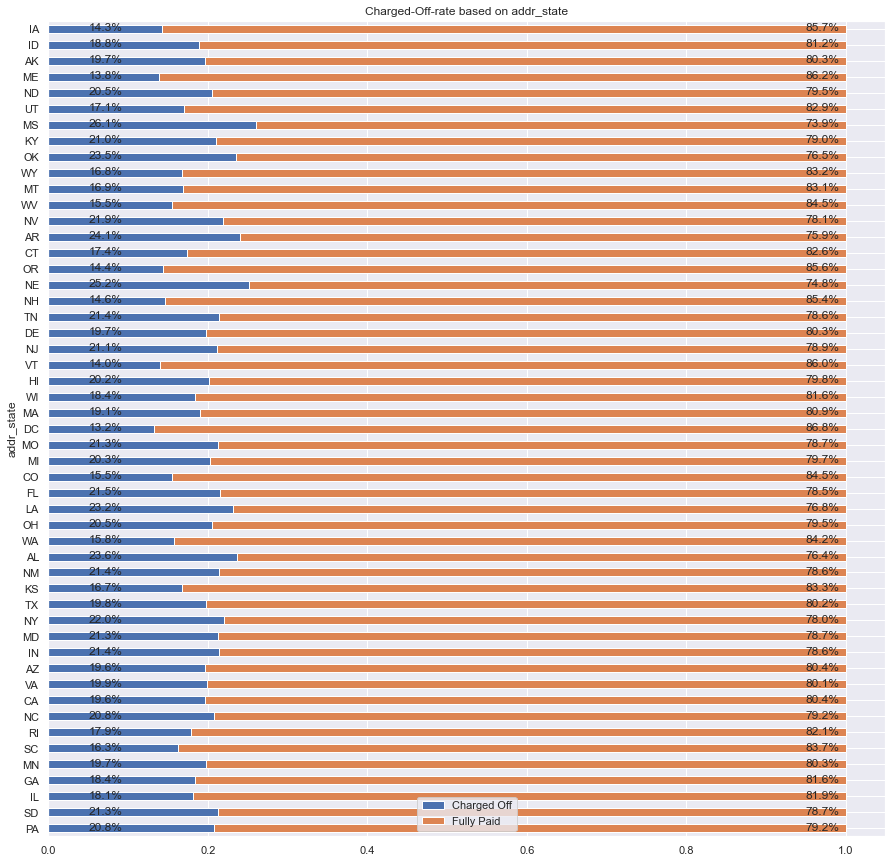

In [31]:
fig, ax =plt.subplots(1,1, figsize = (15, 15))
stacked_hbar_chart(df, 'addr_state', 'loan_status', 'y', ax= ax)
plt.legend(loc= 8)

In [32]:
df['home_ownership'] = df['home_ownership'].apply(lambda x: 'NONE' if x in ["ANY","NONE","OTHER"] else x)

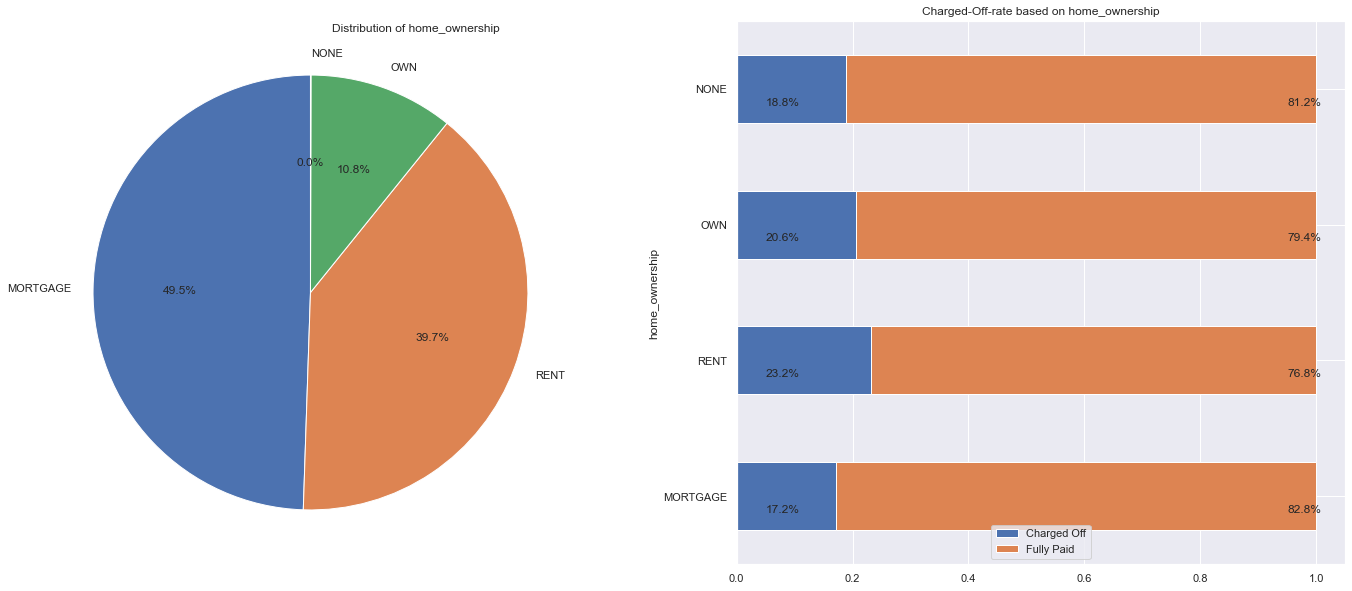

In [33]:
fig, ax =plt.subplots(1,2, figsize = (24, 10))
plot_pie(df, 'home_ownership', ax= ax[0])
stacked_hbar_chart(df,'home_ownership', 'loan_status', 'y', ax= ax[1])
plt.legend(loc= 8)

<AxesSubplot:xlabel='annual_inc', ylabel='loan_status'>

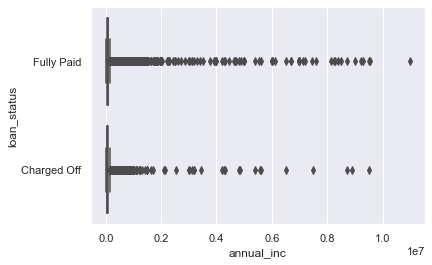

In [34]:
sns.boxplot(df['annual_inc'], df['loan_status'])

In [35]:
df_ =  df[df['annual_inc'] <= 250000]

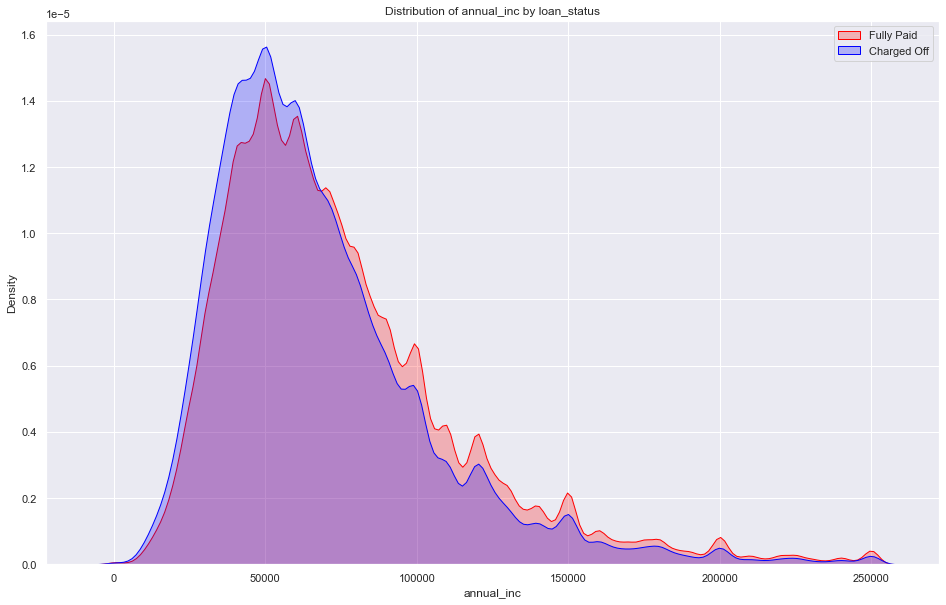

In [36]:
kde_plot(df_, 'annual_inc')
# It seems like  individuals with higher income are more likely to pay off their loans

<AxesSubplot:xlabel='annual_inc', ylabel='loan_status'>

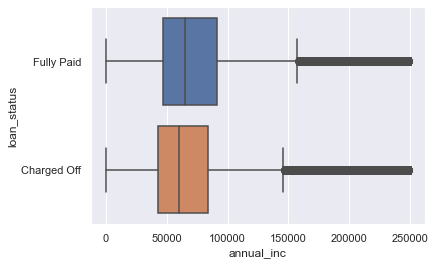

In [37]:
sns.boxplot(df_['annual_inc'], df_['loan_status'])

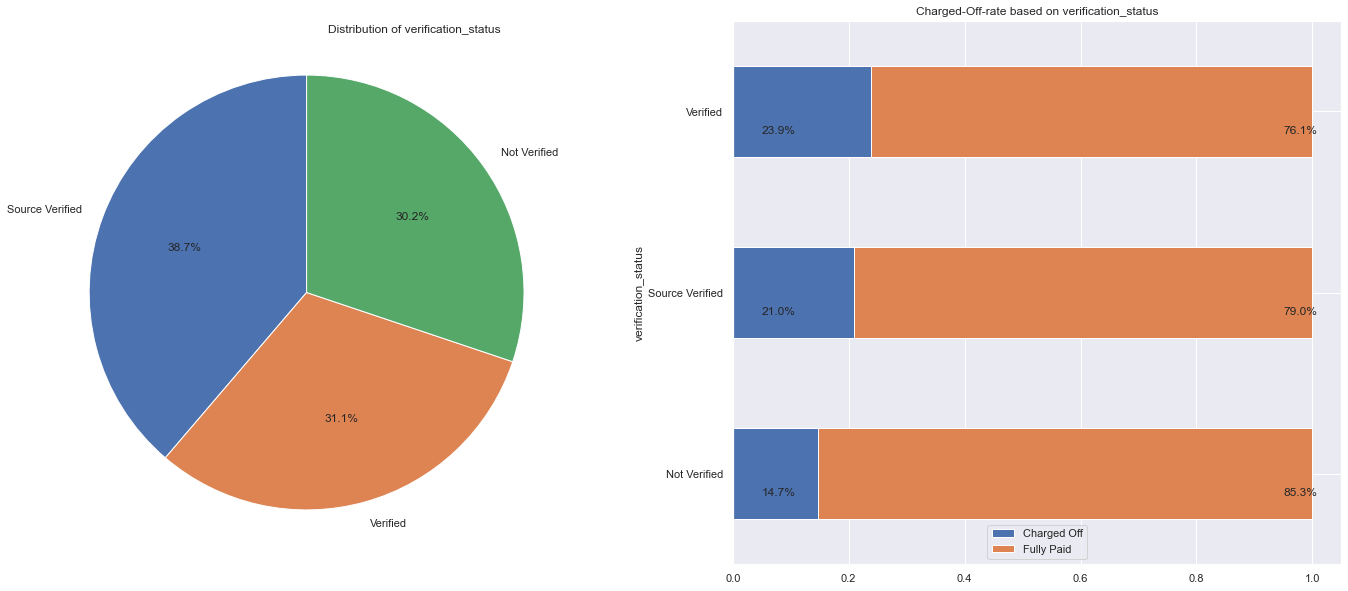

In [38]:
fig, ax =plt.subplots(1,2, figsize = (24, 10))
plot_pie(df, 'verification_status', ax= ax[0])
stacked_hbar_chart(df,'verification_status', 'loan_status', 'y', ax= ax[1])
plt.legend(loc= 8)

<AxesSubplot:xlabel='dti', ylabel='loan_status'>

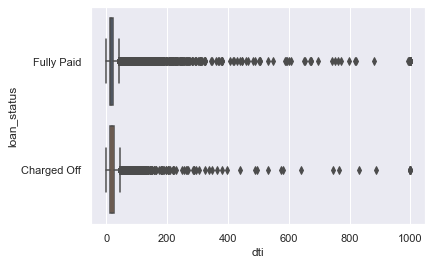

In [39]:
sns.boxplot(df['dti'], df['loan_status'])
# have many ouliners

<AxesSubplot:xlabel='dti', ylabel='loan_status'>

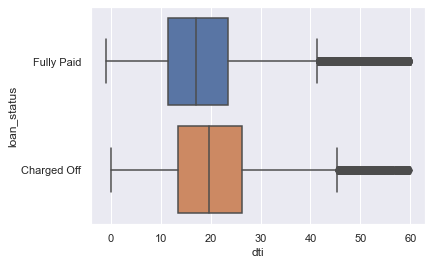

In [40]:
sns.boxplot(df[df['dti'].notnull() & (df['dti']<60)]['dti'], df['loan_status'])

In [41]:
df['open_acc'] = pd.cut(df['open_acc'], bins=[0, 10, 20, 30, 40, 50, 90])
df['open_acc'].value_counts()

(0, 10]     660008
(10, 20]    594737
(20, 30]     80702
(30, 40]      8638
(40, 50]      1005
(50, 90]       206
Name: open_acc, dtype: int64

In [42]:
data_1 = df['open_acc'].value_counts(normalize= True)
data_1[2] = data_1[2] + sum(data_1[3:])
data_1 = data_1[:3]
data_1.index = ["(0, 10]", "(10, 20]", "20+"]
data_1

(0, 10]     0.497925
(10, 20]    0.442086
20+         0.059988
Name: open_acc, dtype: float64

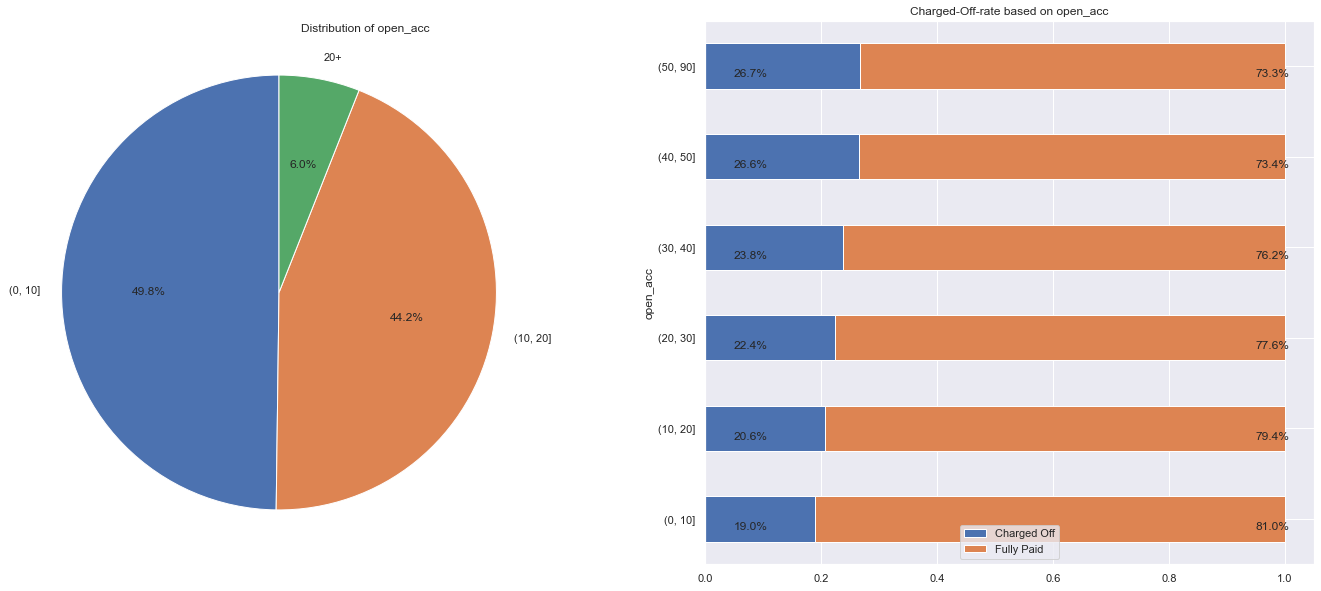

In [43]:
fig, ax =plt.subplots(1,2, figsize = (24, 10))
ax[0].pie(data_1.values, labels=data_1.index, autopct='%1.1f%%', startangle=90)
ax[0].text(0.1, 1.2, f'Distribution of open_acc')
ax[0].get_legend()
stacked_hbar_chart(df, 'open_acc', 'loan_status', 'y', ax= ax[1])
plt.legend(loc= 8)
# The more acc opened the more likely to be charged off

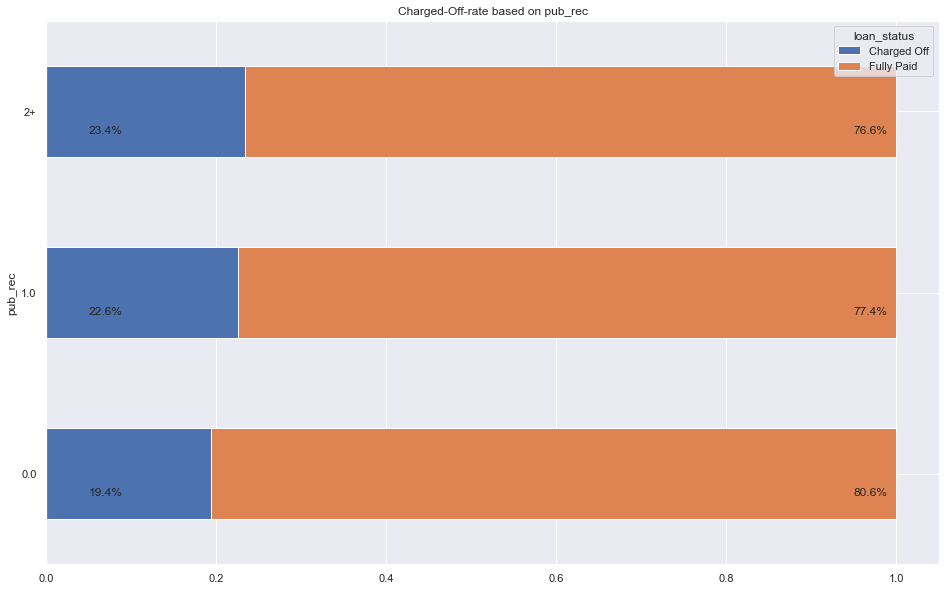

In [44]:
df['pub_rec'] =  df['pub_rec'].apply(lambda x: '2+' if x >= 2 else x)
stacked_hbar_chart(df, 'pub_rec', 'loan_status', 'y')

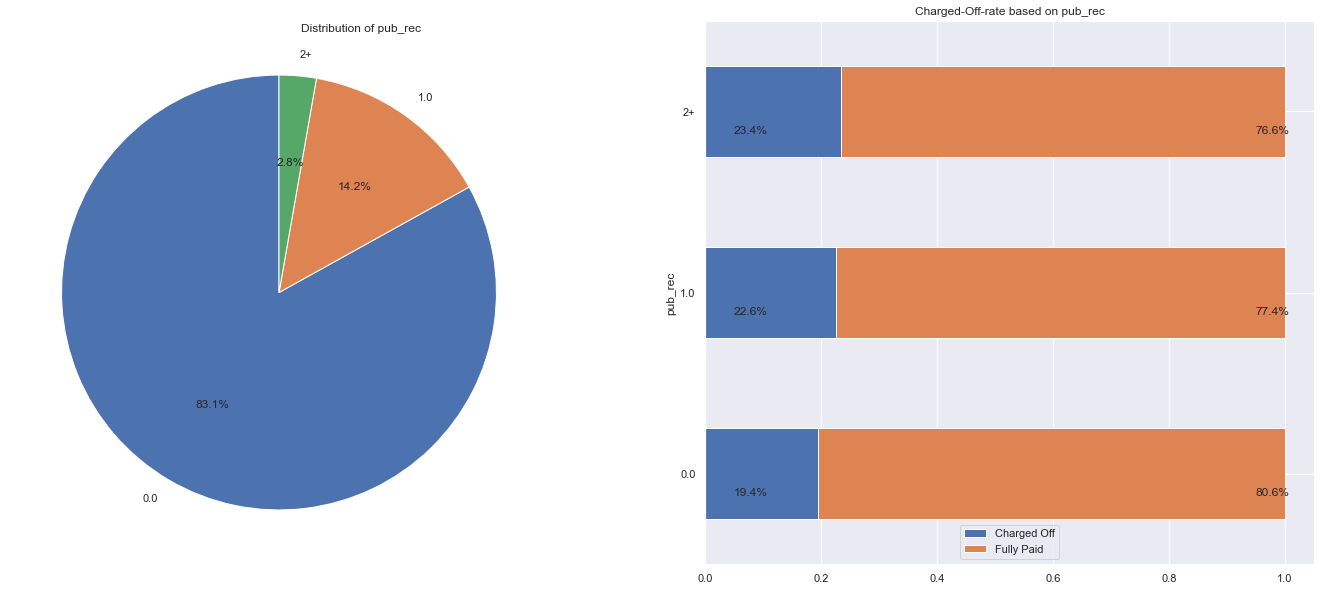

In [45]:
fig, ax =plt.subplots(1,2, figsize = (24, 10))
plot_pie(df, 'pub_rec', ax= ax[0])
stacked_hbar_chart(df,'pub_rec', 'loan_status', 'y', ax= ax[1])
plt.legend(loc= 8)

<AxesSubplot:xlabel='revol_bal', ylabel='loan_status'>

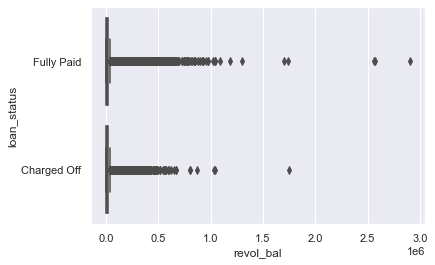

In [46]:
sns.boxplot(df['revol_bal'], df['loan_status'])

<AxesSubplot:xlabel='revol_bal', ylabel='loan_status'>

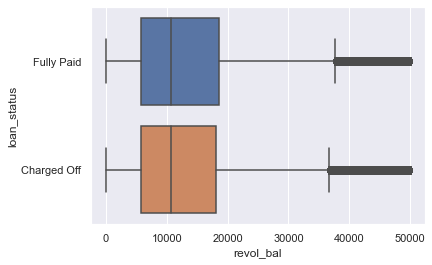

In [47]:
sns.boxplot(df[df['revol_bal'] < 50000]['revol_bal'], df['loan_status'])

In [48]:
df.groupby('loan_status')['revol_bal'].describe()

count          mean           std  min     25%      50%  \
loan_status                                                                
Charged Off   268559.0  15353.500553  18954.349264  0.0  5990.0  11072.0   
Fully Paid   1076751.0  16471.246042  23087.587389  0.0  5931.0  11150.0   

                 75%        max  
loan_status                      
Charged Off  19101.0  1746716.0  
Fully Paid   19925.0  2904836.0

<AxesSubplot:xlabel='revol_util', ylabel='loan_status'>

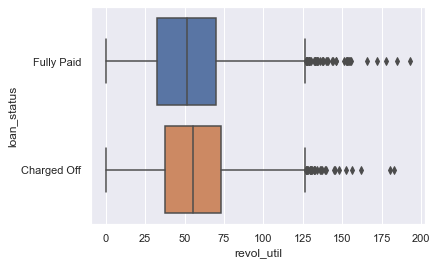

In [49]:
sns.boxplot(df[df['revol_util'] < 200]['revol_util'], df['loan_status'])

In [50]:
df.groupby('loan_status')['revol_util'].describe()

count       mean        std  min   25%   50%   75%    max
loan_status                                                               
Charged Off   268379.0  54.758432  23.865976  0.0  37.4  55.5  73.1  366.5
Fully Paid   1076074.0  51.074672  24.626828  0.0  32.5  51.3  70.1  892.5

In [51]:
df['total_acc'] = pd.cut(df['total_acc'], bins=[2, 10,20, 30, 40, 176])

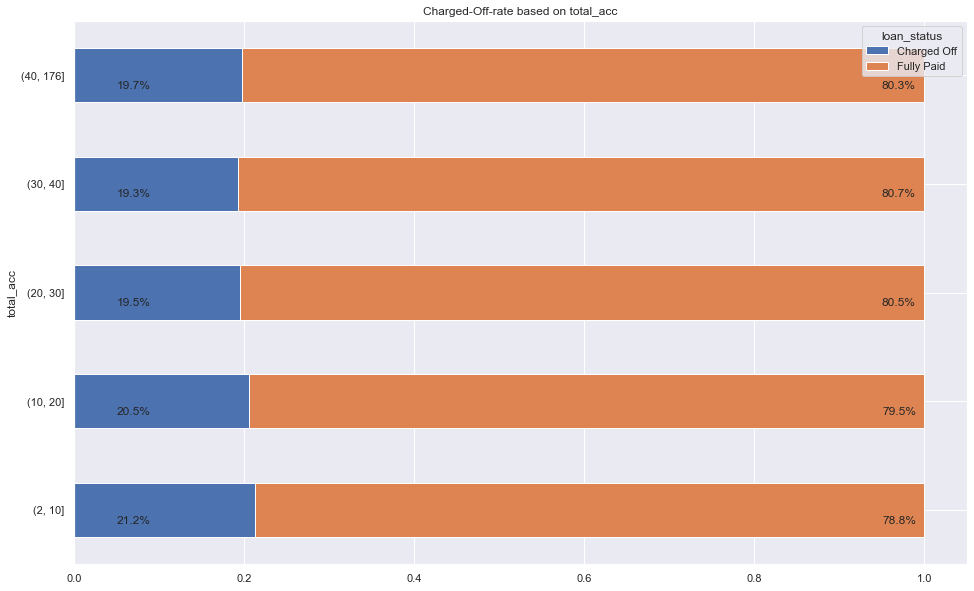

In [52]:
stacked_hbar_chart(df, 'total_acc', 'loan_status', 'y')

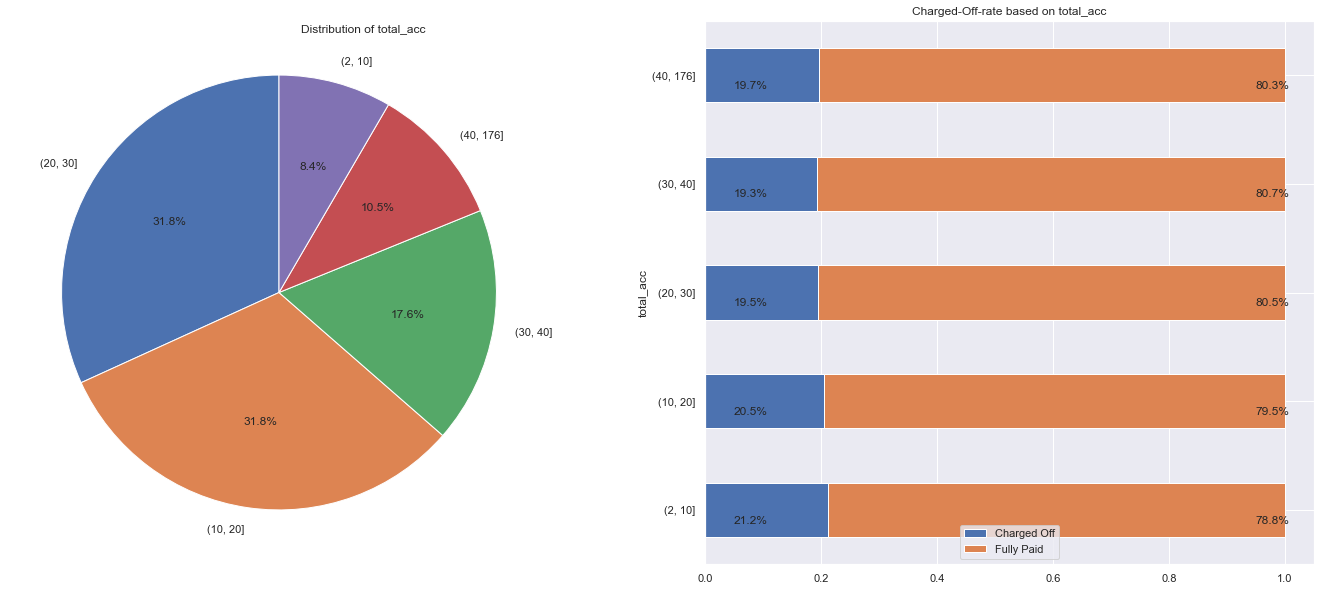

In [53]:
fig, ax =plt.subplots(1,2, figsize = (24, 10))
plot_pie(df, 'total_acc', ax= ax[0])
stacked_hbar_chart(df,'total_acc', 'loan_status', 'y', ax= ax[1])
plt.legend(loc= 8)

In [54]:
df['mort_acc'].fillna(0, inplace= True)

In [55]:
df['mort_acc'] = pd.cut(df['mort_acc'], bins=[0, 1, 2, 3, 4, 5, 51],labels = ['0','1','2','3','4','5+'])

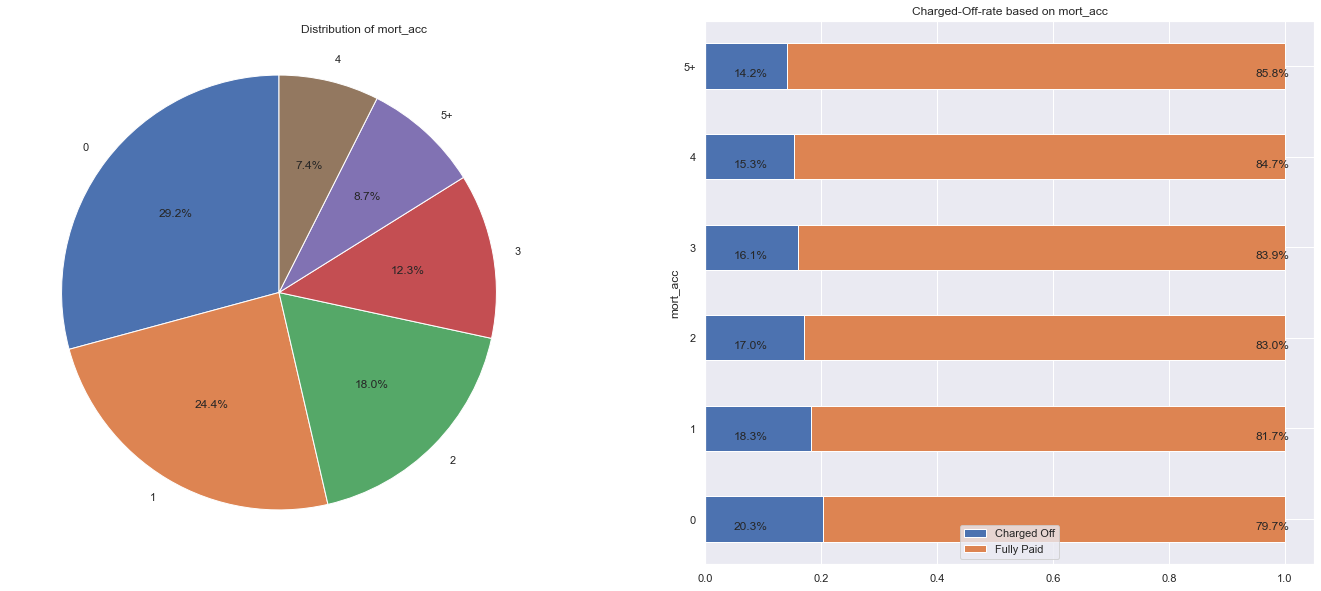

In [56]:
fig, ax =plt.subplots(1,2, figsize = (24, 10))
plot_pie(df, 'mort_acc', ax= ax[0])
stacked_hbar_chart(df,'mort_acc', 'loan_status', 'y', ax= ax[1])
plt.legend(loc= 8)

In [57]:
df['pub_rec_bankruptcies'].max()

12.0

In [58]:
df['pub_rec_bankruptcies'] = pd.cut(df['pub_rec_bankruptcies'], bins=[0, 1, 2, 12],labels = ['0','1','2+'])
df['pub_rec_bankruptcies'].value_counts(normalize= True)
# drop because 94% of this feature is 0

0     0.940570
1     0.046338
2+    0.013092
Name: pub_rec_bankruptcies, dtype: float64

In [59]:
df[['fico_range_low','fico_range_high']].corr()

fico_range_low  fico_range_high
fico_range_low              1.0              1.0
fico_range_high             1.0              1.0

<AxesSubplot:xlabel='fico_range_high', ylabel='loan_status'>

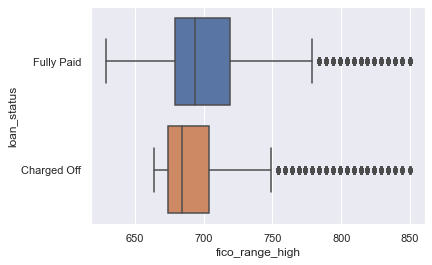

In [60]:
sns.boxplot(df['fico_range_high'], df['loan_status'])

In [61]:
import plotly.graph_objects as go


In [62]:
pivot_df = pd.pivot_table(df, index='addr_state', columns= 'loan_status',values='y', aggfunc=len, sort=False)
pivot_df = pivot_df.div(pivot_df.sum(axis=1),axis=0)


fig = go.Figure(data=go.Choropleth(
    locations=pivot_df.index,
    z = pivot_df['Charged Off'],
    locationmode = 'USA-states',
    colorscale = 'bluyl',
    colorbar_title = "Fully Paid Percentage",
))

fig.update_layout(
    title_text = 'Charged Off Loans 2008-2018 timeframe',
    geo_scope='usa',width=700, height=400 # limit the map scope to USA
)

In [63]:
df_1 = df.groupby('addr_state')['id'].count()

fig = go.Figure(data=go.Choropleth(
    locations=df_1.index,
    z = df_1.values,
    locationmode = 'USA-states',
    colorscale = 'Inferno',
    colorbar_title = "Number of loans",
))

fig.update_layout(
    title_text = 'Number of loans 2008-2018 timeframe',
    geo_scope='usa',width=700, height=400 # limit the map scope to USA
)

In [64]:
pivot_df = pd.pivot_table(df, index='addr_state', columns= 'loan_status',values='y', aggfunc=len, sort=False)
pivot_df = pivot_df.div(pivot_df.sum(axis=1),axis=0)
pivot_df

loan_status  Charged Off  Fully Paid
addr_state                          
PA              0.207921    0.792079
SD              0.213227    0.786773
IL              0.180974    0.819026
GA              0.183927    0.816073
MN              0.197430    0.802570
SC              0.162769    0.837231
RI              0.178675    0.821325
NC              0.207839    0.792161
CA              0.196104    0.803896
VA              0.199422    0.800578
AZ              0.196299    0.803701
IN              0.214082    0.785918
MD              0.213085    0.786915
NY              0.220435    0.779565
TX              0.198223    0.801777
KS              0.167438    0.832562
NM              0.213665    0.786335
AL              0.236321    0.763679
WA              0.157565    0.842435
OH              0.205283    0.794717
LA              0.231821    0.768179
FL              0.214746    0.785254
CO              0.155269    0.844731
MI              0.202957    0.797043
MO              0.212935    0.787065
DC              0.132086    0.867914
MA              0.190528    0.809472
WI              0.183510    0.816490
HI              0.202013    0.797987
VT              0.139517    0.860483
NJ              0.211212    0.788788
DE              0.197462    0.802538
TN              0.214079    0.785921
NH              0.145759    0.854241
NE              0.251813    0.748187
OR              0.143850    0.856150
CT              0.173763    0.826237
AR              0.240868    0.759132
NV              0.219223    0.780777
WV              0.155187    0.844813
MT              0.168716    0.831284
WY              0.167693    0.832307
OK              0.234753    0.765247
KY              0.209829    0.790171
MS              0.260777    0.739223
UT              0.170586    0.829414
ND              0.204744    0.795256
ME              0.138424    0.861576
AK              0.196552    0.803448
ID              0.188277    0.811723
IA              0.142857    0.857143

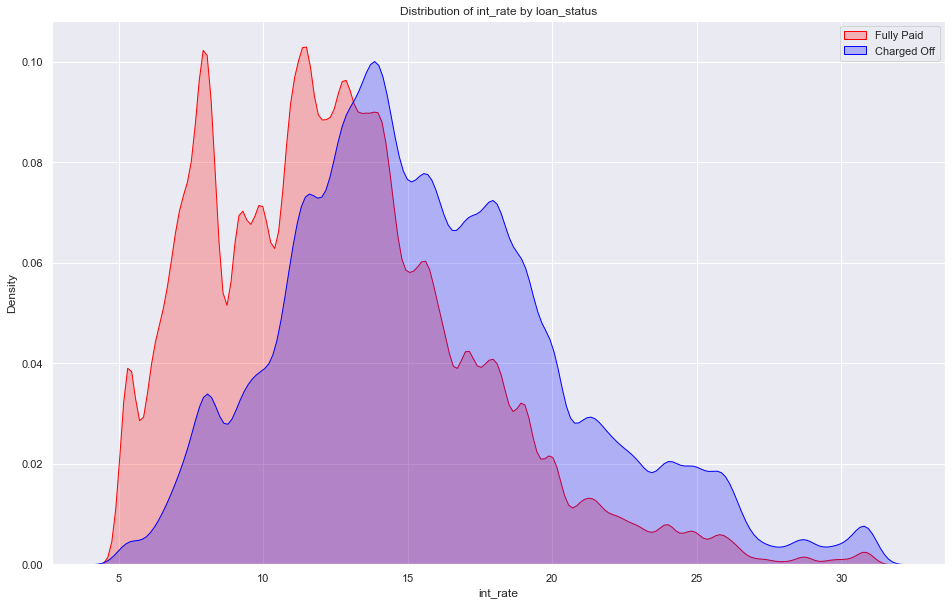

In [65]:
kde_plot(df, 'int_rate')

Text(0.5, 1.0, 'Distribution of dti after remove outliners')

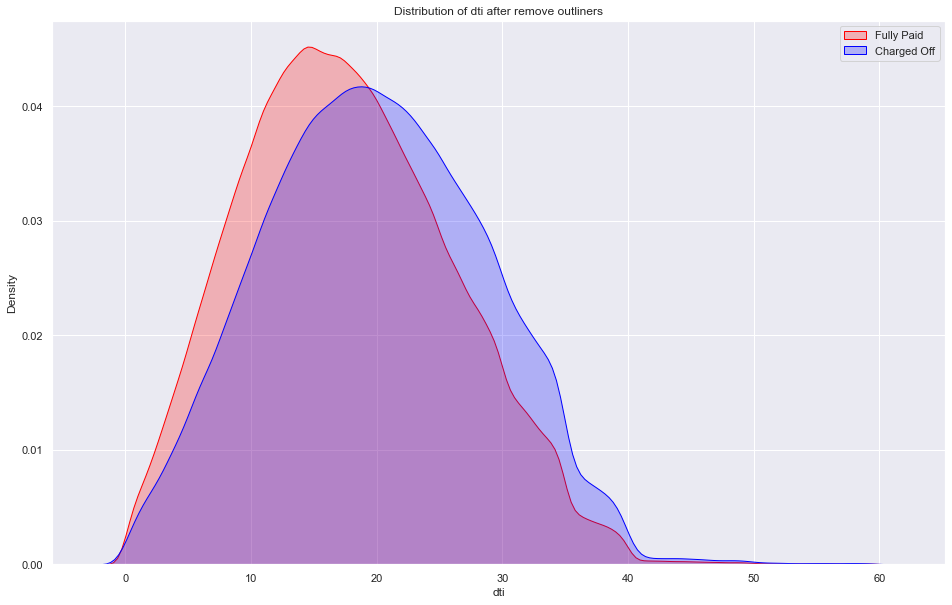

In [66]:
kde_plot(df[df['dti'].notnull() & (df['dti']<60)], 'dti')
plt.title('Distribution of dti after remove outliners')

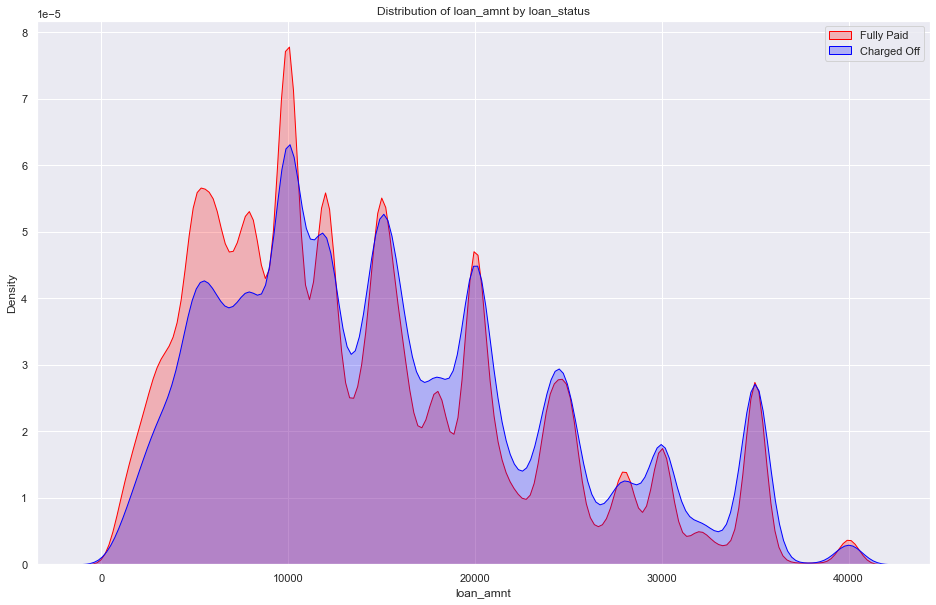

In [67]:
kde_plot(df, 'loan_amnt')